In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

In [2]:
# Specify the path to your CSV file
csv_file_paths = []

# Read the CSV file into a DataFrame
df_2020_2022 = spark.read.csv("salaries/Salaries-2020-2022.csv", header=True, inferSchema=True)
df_2023 = spark.read.csv("salaries/Salaries-2023.csv", header=True, inferSchema=True)

# Drop useless column
df_2020_2022 = df_2020_2022.drop(df_2020_2022.columns[0])

# Merge both files
df = df_2023.union(df_2020_2022)

In [3]:
# Show the DataFrame
df.createOrReplaceTempView("salaries")
df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [4]:
# PARTIE 2 - QUESTION 3a

# Dict to translate from value to (:) value
employment_translation = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'C': 'Contract',
    'I': 'Internship',
    'F': 'Freelance',
    'CT': 'Contract',
    'FL': 'Freelance'
}

# Ensure column are all Strings
df = df.withColumn("employment_type", col("employment_type").cast("string"))

# SQL update is function replace
df = df.replace(employment_translation, subset="employment_type")

df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|      Full-time|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|       Contract|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|       Contract|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [5]:
# PARTIE 2 - QUESTION 3b

# Traditionnal SQL
spark.sql("SELECT job_title, AVG(salary_in_usd) as avg_salary FROM salaries GROUP BY job_title ORDER BY avg_salary DESC LIMIT 10").show()

# SPARK SQL Functions
df.groupBy("job_title")\
    .agg(avg("salary_in_usd").alias("avg_salary"))\
    .orderBy(col("avg_salary").desc())\
    .show(10)

+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Data Science Tech...|          375000.0|
| Data Analytics Lead| 275836.3333333333|
|Principal Data En...|          274000.0|
|Cloud Data Architect|          250000.0|
|           Data Lead|          212500.0|
|Principal Data Sc...|206137.73333333334|
|Director of Data ...|195114.77777777778|
|Machine Learning ...|          192420.0|
|   Applied Scientist| 190264.4827586207|
|Principal Machine...|          190000.0|
+--------------------+------------------+

+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Data Science Tech...|          375000.0|
| Data Analytics Lead| 275836.3333333333|
|Principal Data En...|          274000.0|
|Cloud Data Architect|          250000.0|
|           Data Lead|          212500.0|
|Principal Data Sc...|206137.73333333334|
|Director of Data ...|195114.7777

In [6]:
# PARTIE 2 - QUESTION 3c

# Traditionnal SQL
spark.sql("SELECT job_title, COUNT(*) as job_count FROM salaries GROUP BY job_title ORDER BY job_count DESC LIMIT 10").show()

# SPARK SQL Functions
df.groupBy("job_title").count().withColumnRenamed('count', 'job_count')\
    .orderBy(col("job_count").desc())\
    .show(10)

+--------------------+---------+
|           job_title|job_count|
+--------------------+---------+
|       Data Engineer|     1172|
|      Data Scientist|      983|
|        Data Analyst|      709|
|Machine Learning ...|      330|
|      Data Architect|      112|
|  Analytics Engineer|      107|
|  Research Scientist|       98|
|Data Science Manager|       70|
|   Applied Scientist|       58|
|         ML Engineer|       40|
+--------------------+---------+

+--------------------+---------+
|           job_title|job_count|
+--------------------+---------+
|       Data Engineer|     1172|
|      Data Scientist|      983|
|        Data Analyst|      709|
|Machine Learning ...|      330|
|      Data Architect|      112|
|  Analytics Engineer|      107|
|  Research Scientist|       98|
|Data Science Manager|       70|
|   Applied Scientist|       58|
|         ML Engineer|       40|
+--------------------+---------+
only showing top 10 rows



In [7]:
# PARTIE 2 - QUESTION 3d

# SPARK SQL Functions
    # Group According to Min/Max Salary THEN
    # Group According to Min/Max Salary and Min/Max Job_title THEN
    # Orderby Work_Year Desc
df.groupBy("job_title","work_year")\
    .agg(min("salary_in_usd").alias("min_salary"),max("salary_in_usd").alias("max_salary") )\
    .groupBy("work_year")\
    .agg(\
        min("job_title").alias("min_job_title"), min("min_salary").alias("min_salary"),\
        max("job_title").alias("max_job_title"),max("max_salary").alias("max_salary"))\
    .orderBy(col("work_year").desc())\
    .show()

+---------+--------------------+----------+--------------------+----------+
|work_year|       min_job_title|min_salary|       max_job_title|max_salary|
+---------+--------------------+----------+--------------------+----------+
|     2023|        AI Developer|      7000|Software Data Eng...|    423834|
|     2022|3D Computer Visio...|      5132|  Research Scientist|    430967|
|     2021|3D Computer Visio...|      2859|Staff Data Scientist|    600000|
|     2020|        AI Scientist|      5707|  Staff Data Analyst|    450000|
+---------+--------------------+----------+--------------------+----------+



In [8]:
# PARTIE 2 - QUESTION 3e

# Traditionnal SQL
spark.sql("SELECT job_title, AVG(salary_in_usd) as avg_salary FROM salaries GROUP BY job_title ORDER BY avg_salary DESC").show()

# SPARK SQL Functions
df.groupBy("job_title")\
    .agg(avg("salary_in_usd").alias("avg_salary"))\
    .orderBy(col("avg_salary").desc())\
    .show()

+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Data Science Tech...|          375000.0|
| Data Analytics Lead| 275836.3333333333|
|Principal Data En...|          274000.0|
|Cloud Data Architect|          250000.0|
|           Data Lead|          212500.0|
|Principal Data Sc...|206137.73333333334|
|Director of Data ...|195114.77777777778|
|Machine Learning ...|          192420.0|
|   Applied Scientist| 190264.4827586207|
|Principal Machine...|          190000.0|
|Data Science Manager|185630.15714285715|
|        Head of Data|          175959.2|
|Data Infrastructu...|175051.66666666666|
|Business Intellig...|          174150.0|
|Financial Data An...|          171000.0|
|      Data Architect|163300.92857142858|
|   Research Engineer|163108.37837837837|
|Machine Learning ...|162088.88235294117|
|Director of Data ...|          156738.0|
|   Data Science Lead|        156334.375|
+--------------------+------------

In [9]:
# PARTIE 2 - QUESTION 3f

# Traditionnal SQL
avg_salary_per_year = spark.sql(""" SELECT company_location, AVG(salary_in_usd) as avg_salary FROM salaries
    WHERE job_title = "ML Engineer" GROUP BY company_location ORDER BY avg_salary DESC LIMIT 3""").show()

# SPARK SQL Functions
df.select("job_title","company_location","salary_in_usd")\
    .filter(col("job_title") == "ML Engineer") \
    .groupBy("company_location")\
    .agg(avg("salary_in_usd").alias("avg_salary"))\
    .orderBy(col("avg_salary").desc())\
    .show(3)

+----------------+------------------+
|company_location|        avg_salary|
+----------------+------------------+
|              CA|          185000.0|
|              US|178730.96666666667|
|              JP|           70537.5|
+----------------+------------------+

+----------------+------------------+
|company_location|        avg_salary|
+----------------+------------------+
|              CA|          185000.0|
|              US|178730.96666666667|
|              JP|           70537.5|
+----------------+------------------+
only showing top 3 rows



In [10]:
# PARTIE 2 - QUESTION 3g

# Traditionnal SQL
spark.sql("SELECT experience_level, AVG(salary_in_usd) as avg_salary FROM salaries GROUP BY experience_level ORDER BY avg_salary DESC").show()

# SPARK SQL Functions
df.groupBy("experience_level")\
    .agg(avg("salary_in_usd").alias("avg_salary"))\
    .orderBy(col("avg_salary").desc())\
    .show()

+----------------+------------------+
|experience_level|        avg_salary|
+----------------+------------------+
|              EX|195759.42142857143|
|              SE| 151605.6287553648|
|              MI|101067.32907662082|
|              EN| 74900.54656862745|
+----------------+------------------+

+----------------+------------------+
|experience_level|        avg_salary|
+----------------+------------------+
|              EX|195759.42142857143|
|              SE| 151605.6287553648|
|              MI|101067.32907662082|
|              EN| 74900.54656862745|
+----------------+------------------+



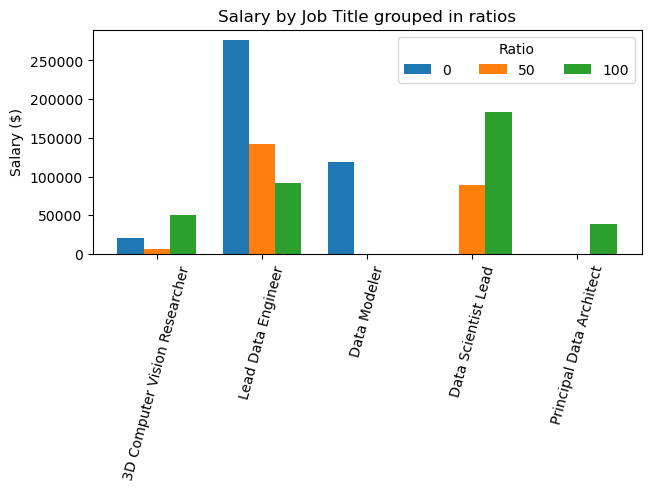

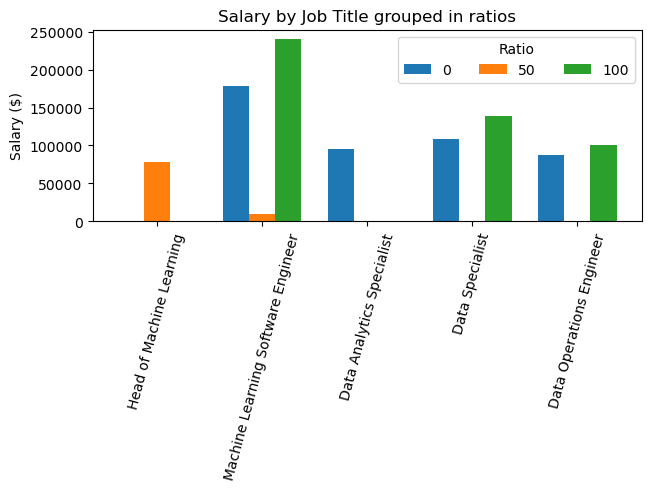

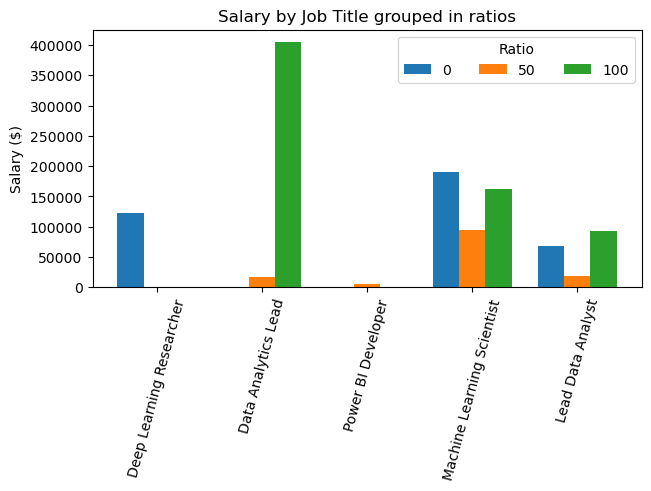

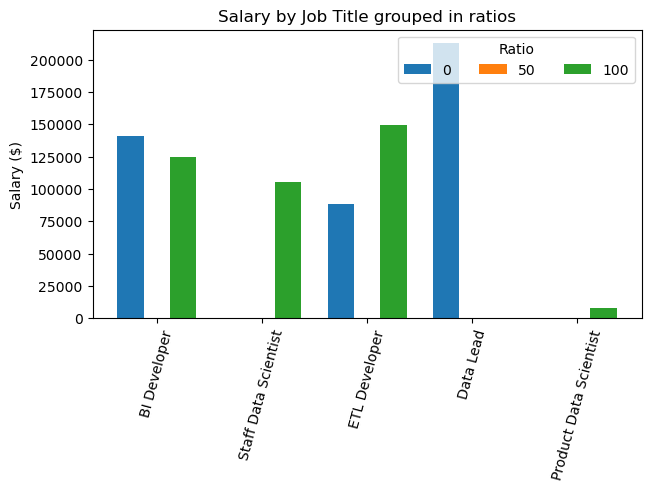

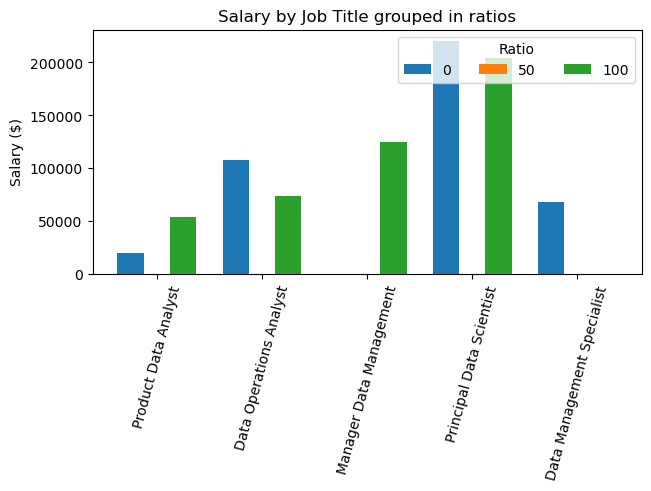

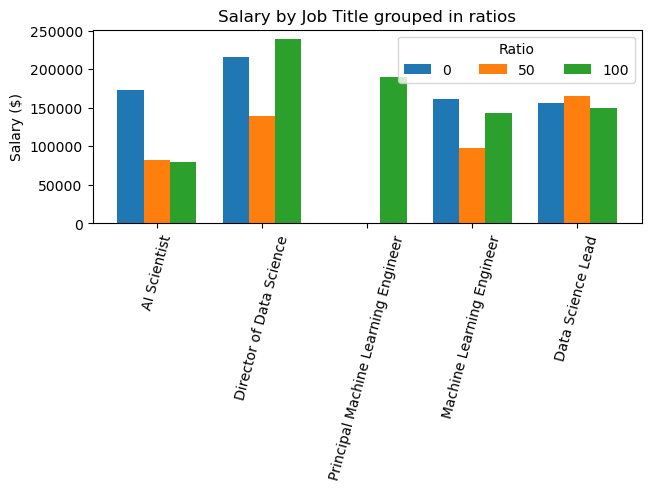

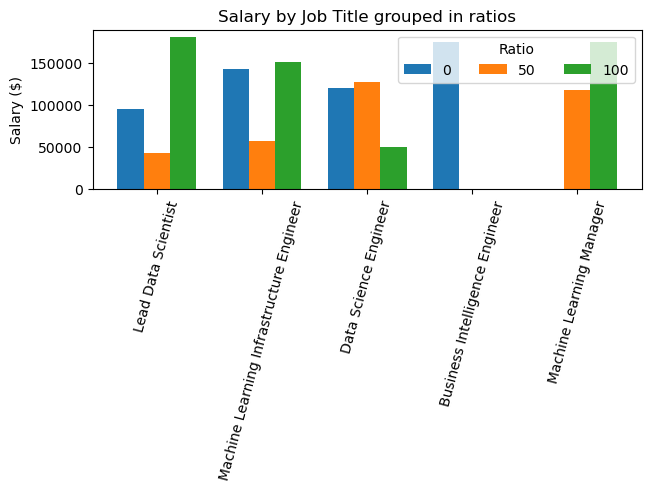

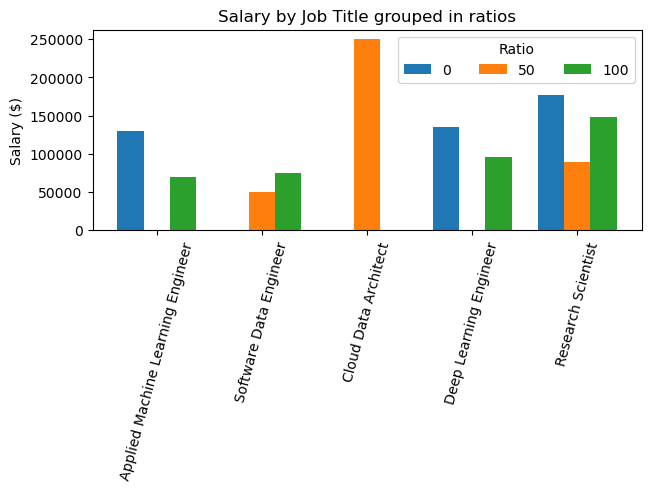

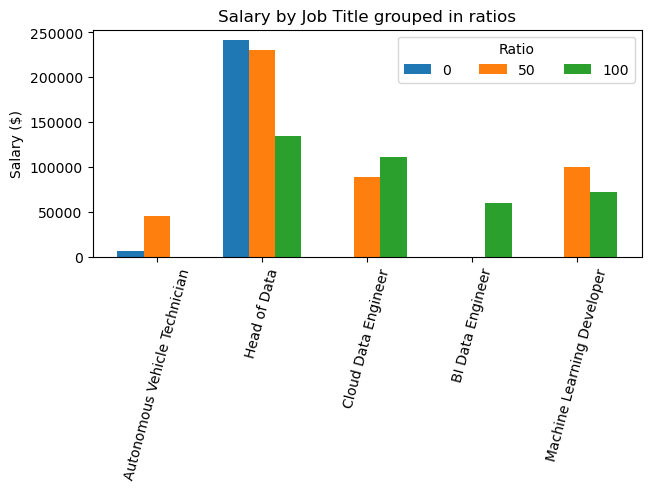

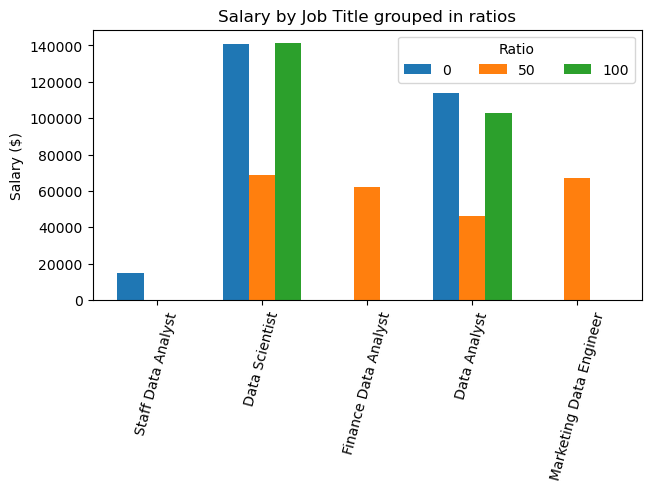

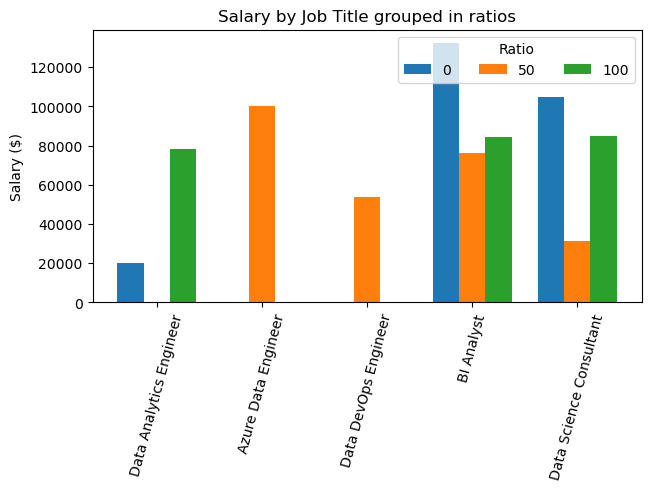

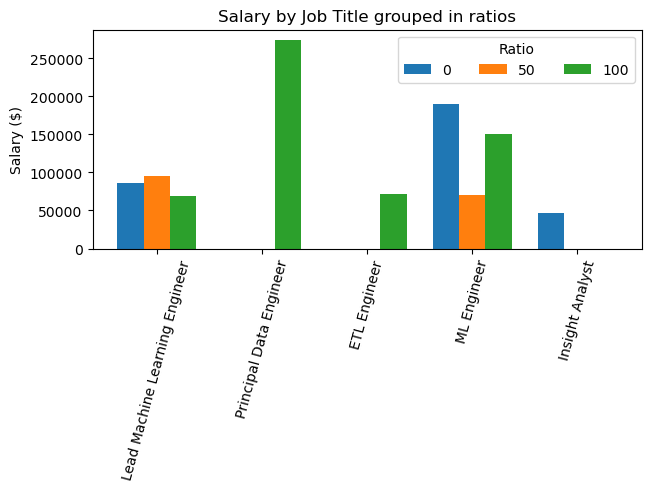

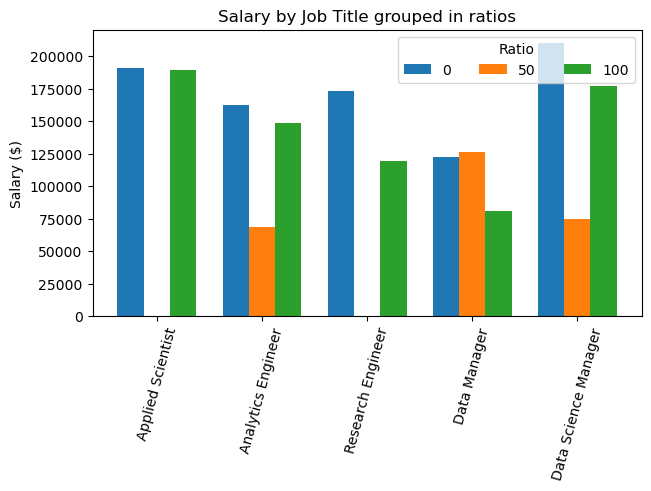

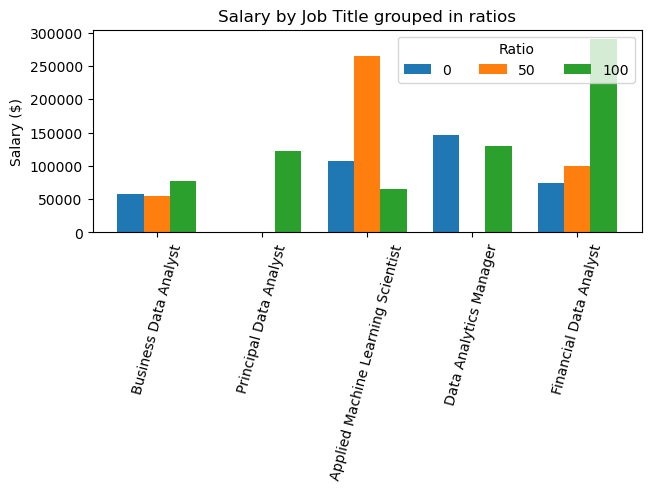

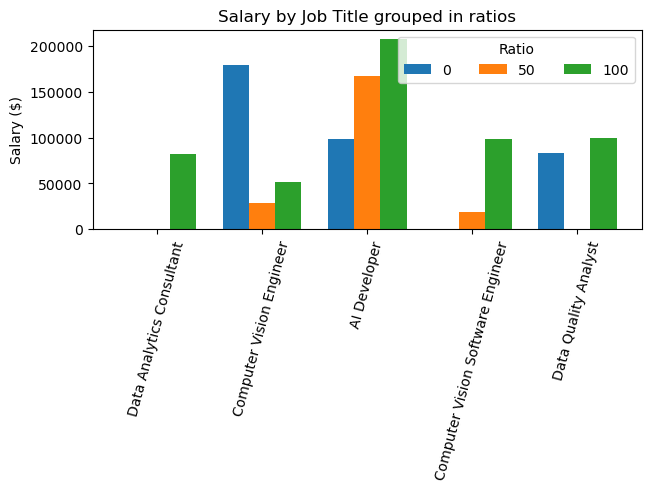

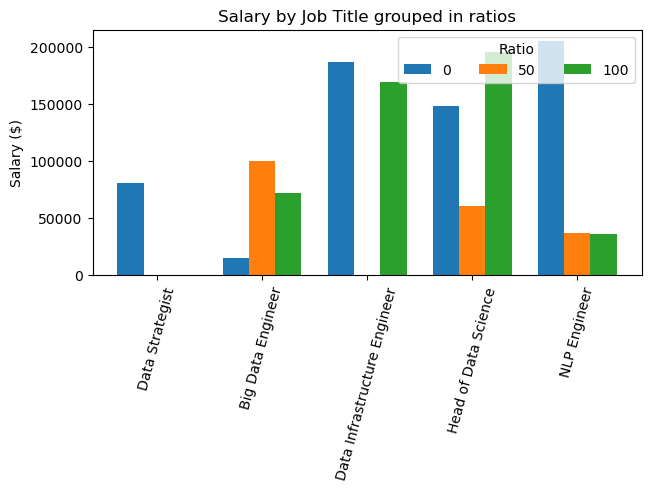

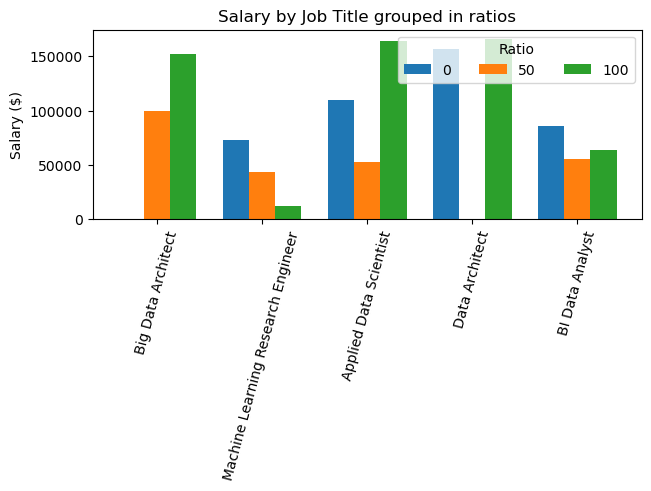

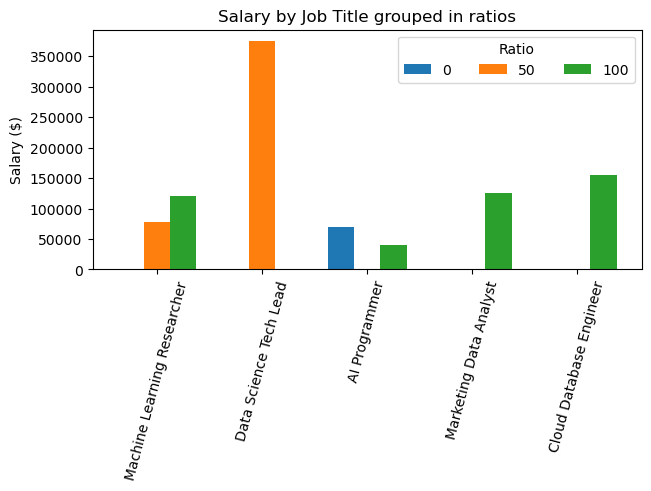

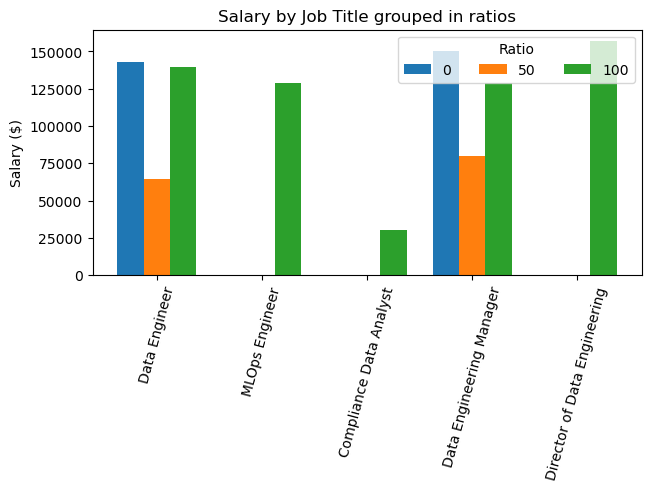

In [14]:
# PARTIE 2 - QUESTION 3h

# Dataframe of all(a) Remote ratios grouped on Salary average and Job title 
a = df.groupBy("remote_ratio","job_title")\
    .agg(avg("salary_in_usd").alias("avg_salary"))\
    .orderBy(col("job_title").asc(),col("remote_ratio").desc())

# Dataframe of all Job Titles
unique = df.select('job_title').distinct()

# Dataframes of all(a) based on Remote ratio value
a_0 = a.filter(col("remote_ratio") == "0")
a_50 = a.filter(col("remote_ratio") == "50")
a_100 = a.filter(col("remote_ratio") == "100")

# Dataframes for all Job Titles based on Remote ratio value
    # Join Job Titles with all(a)
    # Select Only Job title and Salary average
    # Replace Null with 0
a_100 = unique.join(a_100, unique.job_title == a_100.job_title, "left").select(unique.job_title, a_100.avg_salary).fillna(value=0)
a_0 = unique.join(a_0, unique.job_title == a_0.job_title, "left").select(unique.job_title, a_0.avg_salary).fillna(value=0)
a_50 = unique.join(a_50, unique.job_title == a_50.job_title, "left").select(unique.job_title, a_50.avg_salary).fillna(value=0)

# Create Graph in packs of 5
for counter in range(0, 95, 5):
    jobs = unique.toPandas().iloc[counter:counter+5,0]
    salary_per_ratio = {
        '0':a_0.toPandas().iloc[counter:counter+5,-1],
        '50':a_50.toPandas().iloc[counter:counter+5,-1],
        '100':a_100.toPandas().iloc[counter:counter+5,-1]
    }
    # Label locations
    x = np.arange(len(jobs))  
    # Width of the bars
    width = 0.25  
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in salary_per_ratio.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Salary ($)')
    ax.set_title('Salary by Job Title grouped in ratios')
    ax.set_xticks(x + width, jobs)
    ax.set_xticklabels(jobs, rotation=75)
    ax.legend(loc='upper right', ncols=3, title="Ratio")
    
    plt.show()

In [12]:
#spark.stop()